In [3]:
import sys
sys.path.append("../Scripts/")

In [4]:
from conn import connection
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
engine = connection()

Connection success


# Product Analysis

In [7]:
query = """
select
    oi.product_id,
    p.product_category,
    avg(oi.freight_value) as avg_freight,
    avg(p.product_weight_g) as avg_weight,
    avg(p.product_description_length) as avg_description_length,
    sum(oi.price) as total_sales,
    sum(oi.price + oi.freight_value) as total_revenue,
    count(*) as total_items_sold
from order_items oi
join products p on oi.product_id = p.product_id
group by oi.product_id, p.product_category;
"""

In [8]:
df = pd.read_sql(query, engine)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   product_id              32951 non-null  object 
 1   product_category        32341 non-null  object 
 2   avg_freight             32951 non-null  float64
 3   avg_weight              32949 non-null  float64
 4   avg_description_length  32341 non-null  float64
 5   total_sales             32951 non-null  float64
 6   total_revenue           32951 non-null  float64
 7   total_items_sold        32951 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 2.0+ MB


In [10]:
df = df.drop_duplicates(subset=['product_category', 'avg_description_length'])
df.duplicated().sum()

0

In [11]:
df.isnull().sum()

product_id                0
product_category          1
avg_freight               0
avg_weight                0
avg_description_length    1
total_sales               0
total_revenue             0
total_items_sold          0
dtype: int64

In [12]:
df['product_category'] = df['product_category'].str.lower()
df['product_category'] = df['product_category'].str.title()

### Freight cost vs product weight

In [14]:
df[['avg_freight', 'avg_weight']].corr()

,avg_freight,avg_weight
avg_freight,1.000000,0.680666
avg_weight,0.680666,1.000000


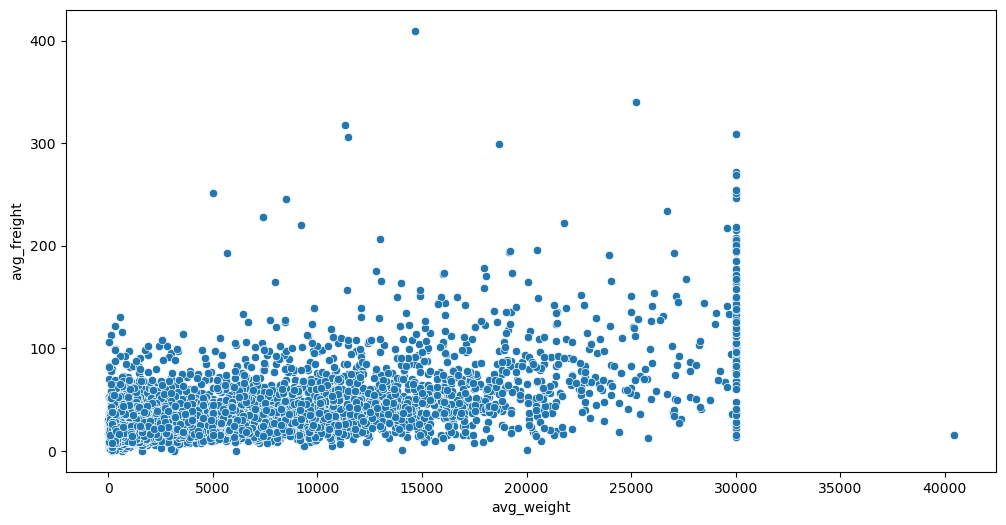

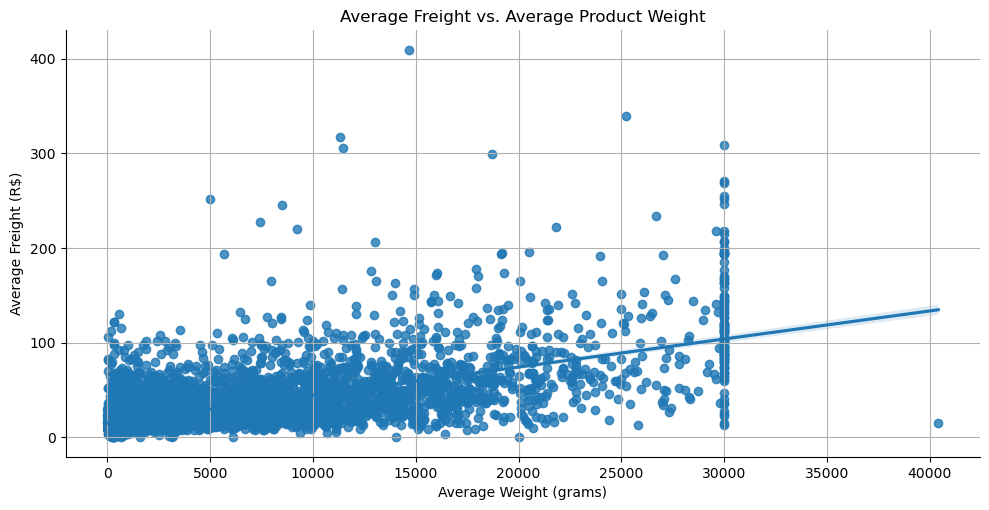

In [15]:
plt.figure(figsize=(12,6))

sns.scatterplot(data=df, x='avg_weight', y='avg_freight')
sns.lmplot(data=df, x='avg_weight', y='avg_freight', aspect=2.0)

plt.title('Average Freight vs. Average Product Weight')
plt.xlabel('Average Weight (grams)')
plt.ylabel('Average Freight (R$)')
plt.grid(True)
plt.show()

### Product descriptions vs sales

In [17]:
df[['avg_description_length', 'total_sales']].corr()

,avg_description_length,total_sales
avg_description_length,1.000000,0.101063
total_sales,0.101063,1.000000


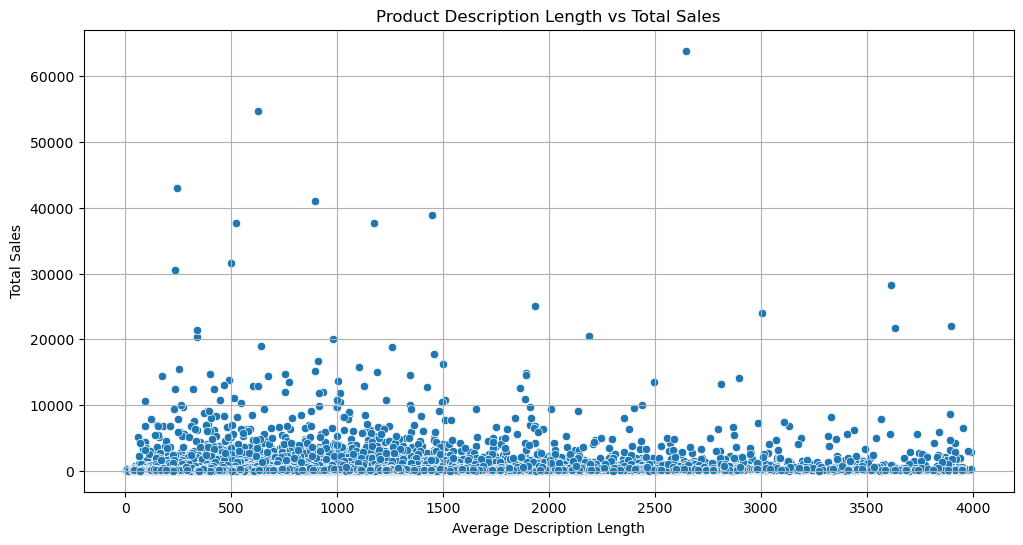

In [18]:
plt.figure(figsize=(12, 6))

sns.scatterplot(data=df, x='avg_description_length', y='total_sales')

plt.title('Product Description Length vs Total Sales')
plt.xlabel('Average Description Length')
plt.ylabel('Total Sales')
plt.grid(True)
plt.savefig('product_vs_sales.png', dpi=300, bbox_inches="tight")
plt.show()

### Top categories by revenue

In [20]:
df.head()

,product_id,product_category,avg_freight,avg_weight,avg_description_length,total_sales,total_revenue,total_items_sold
0,310ae3c140ff94b03219ad0adc3c778f,Health Beauty,14.460000,2000.0,493.0,291.899994,320.819994,2
1,8cab8abac59158715e0d70a36c807415,Sport Leisure,22.175000,1050.0,1392.0,199.800003,244.150003,2
2,b50c950aba0dcead2c48032a690ce817,Sport Leisure,25.245000,1800.0,2584.0,396.000000,496.980000,4
3,5ed9eaf534f6936b51d0b6c5e4d5c2e9,Cool Stuff,18.740476,600.0,693.0,524.639997,918.189999,21
4,35537536ed2b4c561b4018bf3abf54e0,Sport Leisure,20.372308,2100.0,1459.0,4970.000000,5234.839999,13


In [21]:
top_cat = df.groupby('product_category')['total_revenue'].sum().sort_values(ascending=False).reset_index().head()

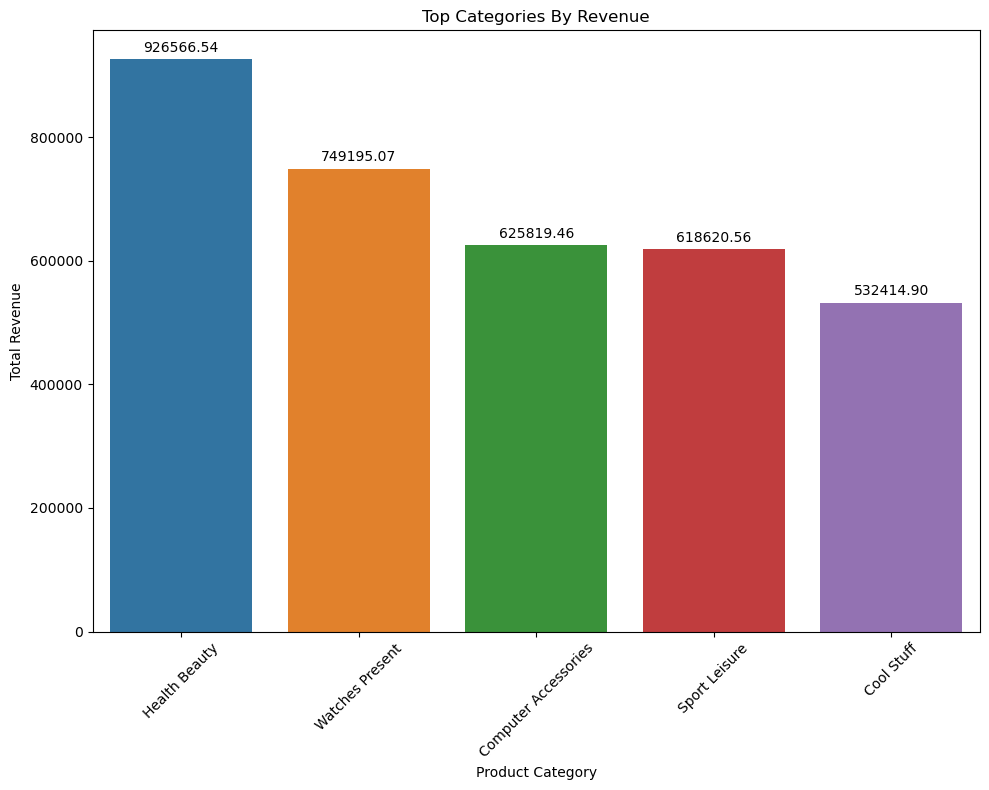

In [22]:
plt.figure(figsize=(10,8)) 

ax = sns.barplot(x='product_category', y='total_revenue', data=top_cat)

plt.title('Top Categories By Revenue')
plt.xlabel('Product Category')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', padding=3)

plt.tight_layout()
plt.show()